In [1]:
"""Run inference on a given lmdb dataset."""

import argparse
import sys
import numpy as np
from pathlib import Path

import lzma
import ase
from ase.io import iread
from ase.db import connect
from activate import data
import glob
import oc20
#from ocpmodels.datasets.lmdb_dataset import LmdbDataset

import torch
import os
import pickle
import os.path as osp
import pandas as pd
from tqdm import tqdm
from typing import Callable, List, Optional
from torch_geometric.data import Data, InMemoryDataset, download_url, extract_tar
from torch_geometric.data import Batch
from torch_geometric.loader.data_list_loader import DataListLoader

sys.path.append("/people/d3x771/projects/chemreasoner/chemreasoner/src")

from nnp.oc import OCAdsorptionCalculator






In [2]:
def init_model(model_type="gemnet-oc-22", batch_size=32):
    if(model_type == "gemnet-t"):
        ads_calc = OCAdsorptionCalculator(
            **{
                "model": "gemnet-t",  # change to gemnet-oc-22 TODO: 06/10/2024
                "traj_dir": Path("irrelevant"),
                "batch_size": 40,
                "device": "cpu",
                "ads_tag": 2,
                "fmax": 0.05,
                "steps": 300,
            }
        )
    else:
        ads_calc = OCAdsorptionCalculator(
            **{

                "model": "gemnet-oc-22",
                "traj_dir": Path("irrelevant"),
                "batch_size": batch_size,
                "device": "cuda",
                "ads_tag": 2,
                "fmax": 0.03,
                "steps": 200,
            }
        )      

    torch_calc = ads_calc.get_torch_model
    return torch_calc


def get_per_sample_embeddings(output_embeddings, batch):
    """
    Given a dictionary comtaining model output per batch of the form:
    {"energy": E_t, "hidden_h":h, "hidden_m":m, 'edge_index':edge_index}
    
    generate, embeddings per model input:
    [embeddings_atomistic_graph1, embeddings_atomistic_graph2.....embeddings_atomistic_graphN]

    """
    data = output_embeddings
    #print(data)
    atom_emb = data['hidden_h']
    edge_emb = data['hidden_m']
    energies = data['energy']
    forces = data['forces']
    graph_embs = []
    for i in range(len(batch.ptr)-1):
        idx_start = batch.ptr[i]
        idx_end = batch.ptr[i+1]
        #print(i, idx_start, idx_end)
        graph_emb = atom_emb[idx_start:idx_end]
        #print(graph_emb.size())
        graph_emb = torch.mean(graph_emb, 0)
        #print(graph_emb.size())
        graph_embs.append(graph_emb)
    return(np.array(graph_embs))

In [3]:
class OC20_Descriptors():
    def __init__(self, descriptor_filepath="/qfs/projects/chemreasoner/data/uq_descriptors/oc20_data_mapping.pkl"):
        with open(descriptor_filepath, "rb") as f:
            self.descriptor_dict = pickle.load(f)
        self.class_name_mapping = ["intermetallics", "metalloids", " non-metals", "halides"]

    def get_descriptors(self, batch):
        """Get the descriptors for the given batch.

        Following uses data mappings from https://github.com/FAIR-Chem/fairchem/blob/daf72a502c6ee19f2c70eaef58eefc233f25362c/DATASET.md
        """
        desc = []
        #for k in batch.structure_id:
        for k in batch.system_id:
            descriptors = self.descriptor_dict[k]
            descriptors["max_millers"] = max([abs(i) for i in descriptors["miller_index"]])
            descriptors["class_name"] = self.class_name_mapping[descriptors["class"]]
            desc.append(self.descriptor_dict[k])

        return desc


In [4]:

def get_uq_dataset(dataset, batch_size, num_training_batches):
    if(dataset == 'OC20'):
        """
            Data format
            z -> atomic numbers
            y -> prediction target/ total energy (optional here)
            pos -> coordinates of all atoms
            f -> forces per atom
            cell -> periodic boundary conditions for calculating neiborhood calculations
        """
        #datadir= '/qfs/projects/chemreasoner/data/OC20/'
        datadir = '/qfs/projects/chemreasoner/torch_lightning_codebase/ocp/data/OC20/'
        dataset = oc20.OC20(datadir, tag='200k')
        loader = DataListLoader(dataset, batch_size=batch_size, shuffle=False)
        data_desc_obj = OC20_Descriptors()
        print(data_desc_obj.class_name_mapping)
       
    else:
        print("UNSUPPORTED DATASET FORMAT, exiting...")
        sys.exit(1)

    X = []
    Y= []
    X_descriptors = []

    torch_calc = init_model(model_type="gemnet-oc-22")
    
    for i, data_list in enumerate(loader):
        if(i < num_training_batches):
            for x in data_list:
                x.atomic_numbers = x.z
                #print(x.atomic_numbers.shape)
                "TB Fixed: hack to set tag for each atom randomly to 0 or 1, "
                "need to be fixed to correct attribute in OC20"
                x.tags = torch.Tensor([0 for i in range(len(x.atomic_numbers))])
                x.tags[-2] = 1

            batch = Batch.from_data_list(data_list)
            print(i, len(batch), batch)
            batch_descriptors = data_desc_obj.get_descriptors(batch)
            #print(type(batch.tags))

            outputs = torch_calc.predict(batch,per_image=False)
            batch_embeddings = get_per_sample_embeddings(torch_calc.model.model_outemb, batch)
            batch_output = outputs['energy']
            #print(batch_embeddings.shap,batch_output.shape)
            
            for emb, out, desc in zip(batch_embeddings, batch_output, batch_descriptors):
                X.append(emb)
                X_descriptors.append(desc)
                Y.append(out)
        else:
            print("finished training on sample batches, exiting..")
            return X, Y, X_descriptors
    return X, Y, X_descriptors

In [5]:
#X, Y, X_descriptors = get_uq_dataset(dataset='OC20', batch_size=32, num_training_batches = 2)


In [6]:
import numpy as np
import os
import pickle
import logging
import xgboost as xgb
 
class GBMRegressor:
    """
    Union approach for Gradient Boosting Machine uncertainty estimation
    from https://link.springer.com/article/10.1186/s13321-023-00753-5 
    """
    def __init__(self, savedir='./', lower_alpha=0.1, upper_alpha=0.9, n_estimators=100):
        """Initialize GBM regressors
        Args:
          savedir (str): Directory to save fit GBM regressors. 
                         (default: :obj:`./`)
          lower_alpha (float): The alpha-quantile of the quantile loss function.
                               Values must be in the range (0.0, 1.0). 
                               (default: :obj:`0.1`)
          upper_alpha (float): The alpha-quantile of the quantile loss function. 
                               Values must be in the range (0.0, 1.0). 
                               (default: :obj:`0.9`)
          n_estimators (int): The number of boosting stages to perform.
                              (default: :obj:`100`)
        """
        self.savedir = savedir
        self.alpha = np.array([lower_alpha, upper_alpha])
        self.n_estimators = n_estimators
        
    @property
    def model_file(self):
        return 'GBMRegressor.pkl'
 
        
    def update(self, embeddings, target):
        """Update GBM models after training epoch."""          
        Xy = xgb.QuantileDMatrix(embeddings, target)
        Xy_test = xgb.QuantileDMatrix(embeddings, target, ref=Xy)

        self.booster = xgb.train(
            {
                "objective": "reg:quantileerror",
                "tree_method": "hist",
                "quantile_alpha": self.alpha,
                "learning_rate": 0.04,
                "max_depth": 5,
                "verbosity": 0,
                "disable_default_eval_metric": True,
            },
            Xy,
            num_boost_round=self.n_estimators,
            )
 
    def predict(self, embeddings):
        """Predict uncertainties for set of embeddings."""
 
        scores = self.booster.inplace_predict(embeddings).T
        return np.abs(scores[0]-scores[1])/2
 
    def _save(self):
        """Save GBM regressor parameters to file."""
        with open(os.path.join(self.savedir, self.model_file), 'wb') as f:
            pickle.dump(self.booster, f)
 
 
    def _load(self):
        """Load trained GBM regressors from file."""
        if os.path.isfile(os.path.join(self.savedir, self.model_file)):
            with open(os.path.join(self.savedir, self.model_file), 'rb') as f:
                self.booster = pickle.load(f)
        else:
            logging.warning(f'No trained GBM regressor found in {self.savedir}. Call GBMRegressor.update to train a model.')

In [8]:
def plot_results(results):
    print(results.groupby('class_name')['uncertainity'].mean())
    print(results.groupby('max_millers')['uncertainity'].mean())
    print(results.groupby('miller_index')['uncertainity'].mean())
    sns.color_palette("pastel")
    sns.displot(data=results, x="uncertainity")
    sns.displot(data=results, x="uncertainity", hue='class_name', multiple="stack", palette="pastel")
    return

In [12]:
batch_size=32
num_training_batches = 2
emb_size = 256
X, Y, X_descriptors = get_uq_dataset(dataset='OC20', batch_size=batch_size, \
                                         num_training_batches = num_training_batches)

['intermetallics', 'metalloids', ' non-metals', 'halides']


Unknown option: -C
usage: git [--version] [--help] [-c name=value]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p|--paginate|--no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           <command> [<args>]


0 32 DataBatch(y=[32], pos=[2320, 3], z=[2320], f=[2320, 3], cell=[32, 3, 3], e_total=[32], e_ref=[32], rcell=[96, 3], name=[32], system_id=[32], idx=[32], natoms=[32], pbc=[96], atomic_numbers=[2320], tags=[2320], batch=[2320], ptr=[33])


device 0:   0%|                                                                                                      | 0/1 [00:00<?, ?it/s]/people/d3x771/.conda/envs/LLM/lib/python3.9/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
device 0:   0%|                                                                                                      | 0/1 [01:15<?, ?it/s]


h.size(), m.size()
torch.Size([2320, 256]) torch.Size([76998, 512])
E.size(), F.size()
torch.Size([32]) torch.Size([2320, 3])
1 32 DataBatch(y=[32], pos=[2391, 3], z=[2391], f=[2391, 3], cell=[32, 3, 3], e_total=[32], e_ref=[32], rcell=[96, 3], name=[32], system_id=[32], idx=[32], natoms=[32], pbc=[96], atomic_numbers=[2391], tags=[2391], batch=[2391], ptr=[33])


device 0:   0%|                                                                                                      | 0/1 [01:13<?, ?it/s]

h.size(), m.size()
torch.Size([2391, 256]) torch.Size([79004, 512])
E.size(), F.size()
torch.Size([32]) torch.Size([2391, 3])
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..


finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished training on sample batches, exiting..
finished trai

In [18]:
import seaborn as sns
import sklearn as sk
import pandas as pd

def run_uq(model_dir, X, Y, X_descriptors):
    uq_model = GBMRegressor(savedir = model_dir)
    #batch_size=32
    #num_training_batches = 2
    #emb_size = 256
    #X, Y, X_descriptors = get_uq_dataset(dataset='OC20', batch_size=batch_size, \
    #                                     num_training_batches = num_training_batches)
    num_samples = batch_size * num_training_batches
    X = np.array(X)
    Y= np.array(Y)
    print(X.shape, Y.shape)
    X = np.reshape(X, (num_samples, emb_size))
    Y = np.reshape(Y, (num_samples, 1))
    print(X.shape, Y.shape)
    #indices = np.arange(len(X))
    X_train, X_test, Y_train, Y_test, desc_train, desc_test = sk.model_selection.train_test_split(X, Y , X_descriptors,  test_size=0.3, random_state=42)
    uq_model.update(X_train,Y_train)
    uq_model._save()
    train_df = pd.DataFrame(desc_train)
    test_df = pd.DataFrame(desc_test)
    
    train_df.to_csv('train.csv', index=False)
    test_df.to_csv('test.csv', index=False)
    Y_pred = uq_model.predict(X_test)
    test_df['uncertainity'] = Y_pred
    results = test_df
    return results
    

(64, 256) (64, 1)
(64, 256) (64, 1)
class_name
 non-metals       90.469910
halides           82.701881
intermetallics    78.425102
metalloids        89.232407
Name: uncertainity, dtype: float32
max_millers
1    77.120338
2    87.047630
Name: uncertainity, dtype: float32
miller_index
(0, 1, 0)      116.628525
(1, 0, 0)       71.668350
(1, 0, 1)       71.264511
(1, 0, 2)       55.981979
(1, 1, 0)       86.485359
(1, 1, 1)       39.554947
(2, -1, -1)     98.949409
(2, -1, 2)      96.394089
(2, 0, -1)     117.899933
(2, 1, 0)      111.880516
(2, 1, 1)       58.284069
(2, 1, 2)       96.771378
(2, 2, 1)       57.464966
Name: uncertainity, dtype: float32


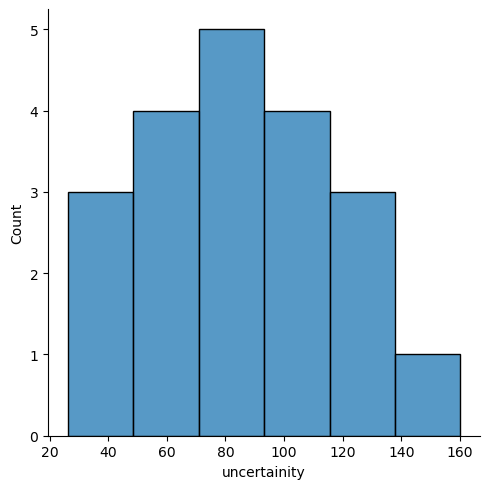

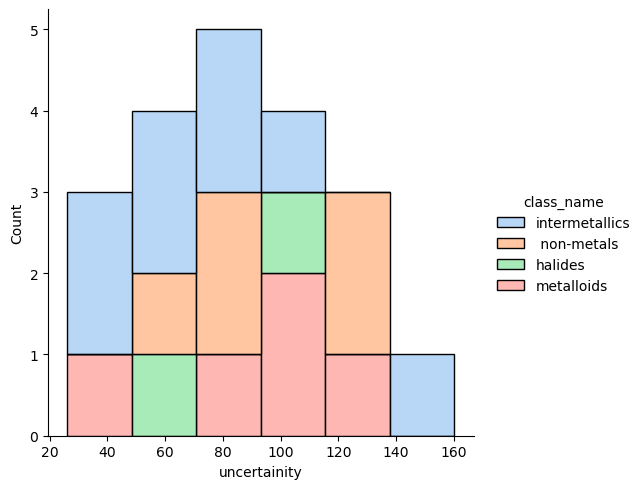

In [19]:
uq_results = run_uq("./", X, Y, X_descriptors)
plot_results(uq_results)